In [2]:
# Reference: https://www.cs.toronto.edu/~vmnih/docs/dqn.pdf

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
#from torch.utils.tensorboard import SummaryWriter

import argparse
from distutils.util import strtobool
import collections
import numpy as np
import gym
from gym.wrappers import TimeLimit, Monitor
from gym.spaces import Discrete, Box, MultiBinary, MultiDiscrete, Space
import time
import random
import os
import matplotlib.pyplot as plt

/opt/conda/lib/python3.7/site-packages/ale_py/roms/utils.py:90: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for external in metadata.entry_points().get(self.group, []):


In [3]:
# TRY NOT TO MODIFY: seeding
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

env = gym.make('Humanoid-v2')
seed = 1234
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
env.seed(seed)

# Hyper params
#discrete_action_space_dim = 101
discrete_action_space_dim = 21
input_dim = env.observation_space.shape[0]
#hidden_dim = 765
hidden_dim = 765
output_dim = env.action_space.shape[0] * discrete_action_space_dim
#output_dim = train_env.action_space.shape[0]
print (input_dim, output_dim)

/home/gswatiseas/gym/gym/envs/registration.py:579: UserWarning: WARN: The environment Humanoid-v2 is out of date. You should consider upgrading to version v3 with the environment ID `Humanoid-v3`.
  f"The environment {spec.id} is out of date. You should consider "


376 357


In [4]:
# modified from https://github.com/seungeunrho/minimalRL/blob/master/dqn.py#
class ReplayBuffer():
    def __init__(self, buffer_limit):
        self.buffer = collections.deque(maxlen=buffer_limit)
    
    def put(self, transition):
        #print ("transition: ", len(transition))
        self.buffer.append(transition)
    
    def sample(self, n):
        mini_batch = random.sample(self.buffer, n)
        s_lst, a_lst, r_lst, s_prime_lst, done_mask_lst = [], [], [], [], []
        
        for transition in mini_batch:
            s, a, r, s_prime, done_mask = transition
            s_lst.append(s)
            a_lst.append(a)
            r_lst.append(r)
            s_prime_lst.append(s_prime)
            done_mask_lst.append(done_mask)

        return np.array(s_lst), np.array(a_lst), \
               np.array(r_lst), np.array(s_prime_lst), \
               np.array(done_mask_lst)
    def flush(self):
        self.buffer.clear()
        
    def len(self):
        return (len(self.buffer))
        

# ALGO LOGIC: initialize agent here:
class QNetwork(nn.Module):
    def __init__(self, env):
        super(QNetwork, self).__init__()
        self.fc_1 = nn.Linear(input_dim, hidden_dim)
        self.fc_1a = nn.Linear(hidden_dim, hidden_dim)
        self.fc_2 = nn.Linear(hidden_dim, output_dim)
        self.maxpool = nn.MaxPool1d(discrete_action_space_dim, stride=discrete_action_space_dim, return_indices=True)

    def forward(self, x, device):
        x = torch.FloatTensor(x).to(device)
        x = torch.tanh(self.fc_1(x))
        x = torch.tanh(self.fc_1a(x))
        x = self.fc_2(x)
        x1, indices = self.maxpool(x)
        return x1, indices

def linear_schedule(start_e: float, end_e: float, duration: int, t: int):
    slope =  (end_e - start_e) / duration
    return max(slope * t + start_e, end_e)


In [51]:
n = discrete_action_space_dim
max_action = 0.4
min_action = -0.4
inc = (max_action - min_action)/ (n-1)
print (inc)
discrete_action_list = [min_action+inc*i for i in range(0, n)]
print (len(discrete_action_list))

0.04
21


In [52]:
def get_actions(action_indices):
    ret_actions = np.zeros(env.action_space.shape[0])
    for i in range(0, len(action_indices)):
        index = action_indices[i] - i*discrete_action_space_dim
        ret_actions[i] = discrete_action_list[index]
    return ret_actions

In [53]:
buffer_size = 100_000
lr = 5e-4

rb = ReplayBuffer(buffer_size)
nfq_network = QNetwork(env).to(device)
optimizer = optim.RMSprop(nfq_network.parameters(), lr=lr)
loss_fn = nn.MSELoss()
print(device.__repr__())
print(nfq_network)


# TRY NOT TO MODIFY: start the game
obs = env.reset()
episode_reward = 0
total_timesteps = 10000
start_e = 0.1
end_e = 0.05
exploration_fraction = 0.5
batch_size = 10
max_grad_norm = 1.0
gamma = 0.99

episode = 0
episode_rewards = []
step_rewards = []

for global_step in range(total_timesteps):

    # ALGO LOGIC: put action logic here
    epsilon = linear_schedule(start_e, end_e, exploration_fraction*total_timesteps, global_step)
    if random.random() < epsilon:
        action = env.action_space.sample()
    else:
        q_vals, action_indices = nfq_network.forward(obs[None, :], device)
        action = get_actions(action_indices.view((-1)))
        #print ("action shape: ", action.shape)

    # TRY NOT TO MODIFY: execute the game and log data.
    next_obs, reward, done, _ = env.step(action)
    episode_reward += reward
    step_rewards.append(reward)

    # ALGO LOGIC: training.
    rb.put((obs, action, reward, next_obs, done))
    
    if global_step != 0 and global_step % batch_size == 0:
        s_obs, s_actions, s_rewards, s_next_obses, s_dones = rb.sample(batch_size)
        rb.flush()
        with torch.no_grad():
            q_next_val, action_next_indices = nfq_network.forward(s_next_obses, device)
            action_next = get_actions(action_indices.view((-1)))
            target_max = q_next_val.sum()
            td_target = torch.Tensor(s_rewards).to(device) + gamma * target_max * (1 - torch.Tensor(s_dones).to(device))
        
        old_q, old_action = nfq_network.forward(s_obs, device)
        
        loss = loss_fn(td_target, torch.sum(old_q, 1))

        # optimize the midel
        optimizer.zero_grad()
        loss.backward()
        nn.utils.clip_grad_norm_(list(nfq_network.parameters()), max_grad_norm)
        optimizer.step()

    # TRY NOT TO MODIFY: CRUCIAL step easy to overlook 
    obs = next_obs

    if done:
        episode += 1
        # TRY NOT TO MODIFY: record rewards for plotting purposes
        print(f"episode={episode}, global_step={global_step}, episode_reward={episode_reward}, epsilon={epsilon}")
        episode_rewards.append(episode_reward)
        obs, episode_reward = env.reset(), 0

device(type='cuda')
QNetwork(
  (fc_1): Linear(in_features=376, out_features=765, bias=True)
  (fc_1a): Linear(in_features=765, out_features=765, bias=True)
  (fc_2): Linear(in_features=765, out_features=357, bias=True)
  (maxpool): MaxPool1d(kernel_size=21, stride=21, padding=0, dilation=1, ceil_mode=False)
)
episode=1, global_step=16, episode_reward=83.43821891922829, epsilon=0.09984000000000001
episode=2, global_step=44, episode_reward=137.5266801142827, epsilon=0.09956000000000001
episode=3, global_step=70, episode_reward=130.05478945612109, epsilon=0.0993
episode=4, global_step=92, episode_reward=111.20105200844205, epsilon=0.09908
episode=5, global_step=115, episode_reward=116.00636580917852, epsilon=0.09885000000000001
episode=6, global_step=137, episode_reward=111.04723915019947, epsilon=0.09863000000000001
episode=7, global_step=157, episode_reward=101.32014346737193, epsilon=0.09843
episode=8, global_step=180, episode_reward=115.38593453570782, epsilon=0.09820000000000001
epi

episode=97, global_step=2491, episode_reward=129.7557983056097, epsilon=0.07509
episode=98, global_step=2517, episode_reward=128.80553733478098, epsilon=0.07483000000000001
episode=99, global_step=2544, episode_reward=134.11387562420222, epsilon=0.07456
episode=100, global_step=2571, episode_reward=132.83445209371223, epsilon=0.07429
episode=101, global_step=2599, episode_reward=141.22027420248003, epsilon=0.07401
episode=102, global_step=2626, episode_reward=134.32744408336694, epsilon=0.07374
episode=103, global_step=2653, episode_reward=134.5640523155868, epsilon=0.07347000000000001
episode=104, global_step=2681, episode_reward=139.96132201253184, epsilon=0.07319
episode=105, global_step=2708, episode_reward=134.3907817863296, epsilon=0.07292
episode=106, global_step=2736, episode_reward=138.8379001568971, epsilon=0.07264000000000001
episode=107, global_step=2763, episode_reward=135.08771641181806, epsilon=0.07237
episode=108, global_step=2789, episode_reward=130.09632159758047, eps

episode=198, global_step=5216, episode_reward=109.5021501549931, epsilon=0.05
episode=199, global_step=5242, episode_reward=128.9056201090441, epsilon=0.05
episode=200, global_step=5270, episode_reward=138.00780544237801, epsilon=0.05
episode=201, global_step=5297, episode_reward=134.9096384054337, epsilon=0.05
episode=202, global_step=5324, episode_reward=136.24803402878246, epsilon=0.05
episode=203, global_step=5350, episode_reward=128.5738116724674, epsilon=0.05
episode=204, global_step=5378, episode_reward=141.72955201789765, epsilon=0.05
episode=205, global_step=5404, episode_reward=129.8566711929282, epsilon=0.05
episode=206, global_step=5430, episode_reward=129.41930075378096, epsilon=0.05
episode=207, global_step=5456, episode_reward=128.98234802205275, epsilon=0.05
episode=208, global_step=5484, episode_reward=138.37112499761673, epsilon=0.05
episode=209, global_step=5510, episode_reward=129.60603649758255, epsilon=0.05
episode=210, global_step=5536, episode_reward=128.7274849

episode=307, global_step=8127, episode_reward=128.9360330575304, epsilon=0.05
episode=308, global_step=8154, episode_reward=135.05422474397358, epsilon=0.05
episode=309, global_step=8182, episode_reward=139.60065885424535, epsilon=0.05
episode=310, global_step=8209, episode_reward=135.3232211055637, epsilon=0.05
episode=311, global_step=8235, episode_reward=129.81864218993812, epsilon=0.05
episode=312, global_step=8262, episode_reward=134.93830464705502, epsilon=0.05
episode=313, global_step=8288, episode_reward=129.7618947568236, epsilon=0.05
episode=314, global_step=8309, episode_reward=105.57373781869367, epsilon=0.05
episode=315, global_step=8337, episode_reward=139.7892778062027, epsilon=0.05
episode=316, global_step=8367, episode_reward=151.29187570827835, epsilon=0.05
episode=317, global_step=8393, episode_reward=130.21935179090454, epsilon=0.05
episode=318, global_step=8420, episode_reward=133.68611371636112, epsilon=0.05
episode=319, global_step=8448, episode_reward=140.865152

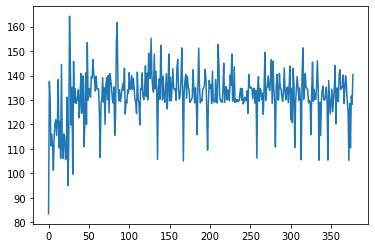

In [54]:
plt.plot(episode_rewards)